In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:57231")
client

Client Scheduler: tcp://127.0.0.1:57231 Dashboard: http://127.0.0.1:36333/status,Cluster Workers: 6 Cores: 30 Memory: 127.00 GB


In [2]:
import numpy as np
import xarray as xr
import gsw
from xmitgcm import open_mdsdataset
from xgcm.grid import Grid
from MITgcmutils import jmd95
from fastjmd95 import rho as densjmd95
from dask.diagnostics import ProgressBar
import os.path as op
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
rdir = '/tank/chaocean/'
ddir = '/tank/topog/tuchida/TWA/'

In [4]:
# year = 1965

z10 = 1
dnf = 2160
grav = 9.81
nensembs = 1
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
Cp = 3.994e3
ystart = -15
yend = 50

In [5]:
xchunk = 250
# year = 1963

# ntimes = np.arange(1416960+dnf,1574640+dnf,dnf,dtype=int)
# ntimes = np.arange(1259280+dnf,1416960+dnf,dnf,dtype=int)
# ntimes = np.arange(1101600+dnf,1259280+dnf,dnf,dtype=int)
# ntimes = np.arange( 943920+dnf,1101600+dnf,dnf,dtype=int)
# ntimes = np.arange( 788400    , 943920+dnf,dnf,dtype=int)
for year in range(1963,1968):
    if year == 1963:
        ntimes = np.arange( 788400+dnf, 943920+dnf,dnf,dtype=int)
    elif year == 1964:
        ntimes = np.arange( 943920+dnf,1101600+dnf,dnf,dtype=int)
    elif year == 1965:
        ntimes = np.arange(1101600+dnf,1259280+dnf,dnf,dtype=int)
    elif year == 1966:
        ntimes = np.arange(1259280+dnf,1416960+dnf,dnf,dtype=int)
    else:
        ntimes = np.arange(1416960+dnf,1574640+dnf,dnf,dtype=int)
        
    for itime in ntimes:
        for nmemb in range(24,36):
            if nmemb == 24:
                ds = open_mdsdataset(op.join(rdir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                             % (nmemb,year)), 
                                     grid_dir=op.join(rdir,'grid_chaO/gridMIT_update1/'),
                                     prefix=['diag_ocnSnap'], 
                                     delta_t=2e2, iters=itime, 
                                     chunks={'XC':xchunk,'XG':xchunk}
                                    ).isel(time=-1)
            else:
                ds = xr.concat([ds, open_mdsdataset(op.join(rdir,
                                                            'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                                            % (nmemb,year)), 
                                                    grid_dir=op.join(rdir,
                                                                     'grid_chaO/gridMIT_update1/'),
                                                    prefix=['diag_ocnSnap'], 
                                                    delta_t=2e2, iters=itime, 
                                                    chunks={'XC':xchunk,'XG':xchunk}
                                                   ).isel(time=-1)],
                               dim='nmemb')
        ds.coords['nmemb'] = ('nmemb',range(12))
        ds = ds.chunk({'nmemb':nensembs})

        dHT0 = xr.open_dataset(op.join(ddir,'IC_temperature-bias_%2dS-%2dN.nc'
                                       % (np.abs(ystart),yend))
                              ).dHT0.chunk({'nmemb':nensembs})
        theta = ds.THETA - dHT0
        pot_rho = xr.apply_ufunc(densjmd95, 
                                 ds.SALT.mean('nmemb'), 
                                 theta.mean('nmemb'),
                                 0., # pressure in [dbar]!!!!
                                 dask='parallelized', output_dtypes=[float,]
                                ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)).fillna(0.)

        nMLD = xr.DataArray(np.nanargmin(np.abs(pot_rho.isel(Z=slice(z10,None))
                                                - pot_rho.isel(Z=z10) - 0.03), 
                                         axis=0) + z10,
                            dims=pot_rho.isel(Z=0).dims, coords=pot_rho.isel(Z=0).coords
                           ).where(ds.maskInC!=0.).compute()

        zz, _ = xr.broadcast(ds.Z, ds.hFacC.sel(YC=slice(ystart-12**-1,
                                                         yend+2*12**-1))
                            )

        MLD = zz.isel(Z=nMLD.fillna(0.).astype(int)
                     ).where(ds.maskInC!=0.)

        MLD.to_dataset(name='MLD').to_netcdf(op.join(ddir,'%4d/MLD_adjusted_%010d.nc' 
                                                     % (year,itime)))
        del nMLD, MLD, zz
        print(itime)

814320
816480
818640
820800
822960
825120
827280
829440
831600
833760
835920
838080
840240
842400
844560
846720
848880
851040
853200
855360
857520
859680
861840
864000
866160
868320
870480
872640
874800
876960
879120
881280
883440
885600
887760
889920
892080
894240
896400
898560
900720
902880
905040
907200
909360
911520
913680
915840
918000
920160
922320
924480
926640
928800
930960
933120
935280
937440
939600
941760
943920
946080
948240
950400
952560
954720
956880
959040
961200
963360
965520
967680
969840
972000
974160
976320
978480
980640
982800
984960
987120
989280
991440
993600
995760
997920
1000080
1002240
1004400
1006560
1008720
1010880
1013040
1015200
1017360
1019520
1021680
1023840
1026000
1028160
1030320
1032480
1034640
1036800
1038960
1041120
1043280
1045440
1047600
1049760
1051920
1054080
1056240
1058400
1060560
1062720
1064880
1067040
1069200
1071360
1073520
1075680
1077840
1080000
1082160
1084320
1086480
1088640
1090800
1092960
1095120
1097280
1099440
1101600
1103760
110592

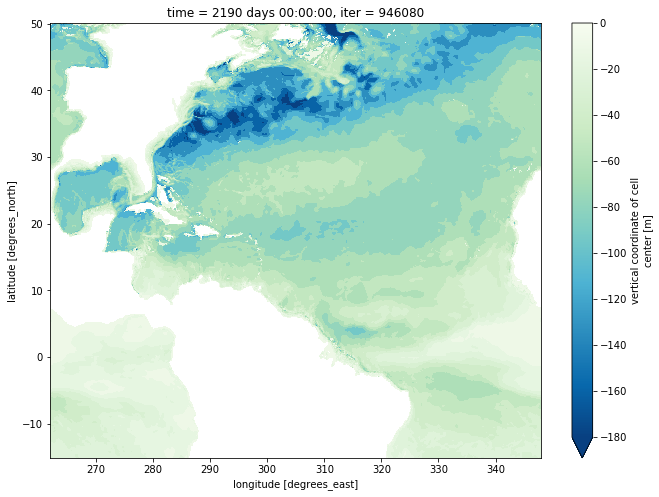

In [11]:
xr.open_dataset(op.join(ddir,'1964/MLD_adjusted_0000946080.nc')
               ).MLD.plot(cmap='GnBu_r', vmin=-180, vmax=0, figsize=(11,8))

In [9]:
for year in range(1963,1968):
    if year == 1963:
#         ds = open_mdsdataset(op.join(rdir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
#                                          % (24,year)), 
#                              grid_dir=op.join(rdir,'grid_chaO/gridMIT_update1/'),
#                              prefix=['diag_ocnSnap'], delta_t=2e2,
#                             )
        MLD = xr.open_mfdataset(op.join(ddir,'%4d/MLD_adjusted_*.nc' 
                                        % (year)),
                                concat_dim='time'
                               ).MLD.sel(YC=slice(30,40),XC=slice(290,310))
    else:
        MLD = xr.concat([MLD, xr.open_mfdataset(op.join(ddir,'%4d/MLD_adjusted_*.nc' 
                                                        % (year)),
                                                concat_dim='time'
                                               ).MLD.sel(YC=slice(30,40),XC=slice(290,310))
                        ], dim='time')
MLD = MLD.chunk({'time':1})
MLD

/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  # Remove the CWD from sys.path while we load stuff.
/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdatas

<xarray.DataArray 'MLD' (time: 365, YC: 120, XC: 232)>
dask.array<concatenate, shape=(365, 120, 232), dtype=float32, chunksize=(1, 120, 232), chunktype=numpy.ndarray>
Coordinates:
    maskC    (YC, XC) bool dask.array<chunksize=(120, 232), meta=np.ndarray>
    hFacC    (YC, XC) float32 dask.array<chunksize=(120, 232), meta=np.ndarray>
    Depth    (YC, XC) float32 dask.array<chunksize=(120, 232), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(120, 232), meta=np.ndarray>
    rA       (YC, XC) float32 dask.array<chunksize=(120, 232), meta=np.ndarray>
  * YC       (YC) float64 30.0 30.08 30.17 30.25 ... 39.67 39.75 39.83 39.92
  * XC       (XC) float32 290.0551 290.14117 290.22723 ... 309.84857 309.93463
    PHrefC   (time, YC, XC) float32 dask.array<chunksize=(1, 120, 232), meta=np.ndarray>
    drF      (time, YC, XC) float32 dask.array<chunksize=(1, 120, 232), meta=np.ndarray>
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) timedelta64[ns] 1825 days 1830 days ... 3640 days 3645 days
    Z        (time, YC, XC) float64 dask.array<chunksize=(1, 120, 232), meta=np.ndarray>
Attributes:
    standard_name:  depth
    long_name:      vertical coordinate of cell center
    units:          m
    positive:       down
    axis:           Z

(716601.0, 718431.0)

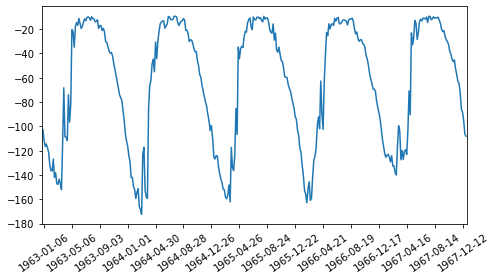

In [13]:
time = np.concatenate((np.concatenate((np.concatenate((np.concatenate((
                       np.arange('1963-01-01','1963-12-31',np.timedelta64(5,'D'),
                                 dtype='datetime64'),
                       np.arange('1964-01-01','1964-12-31',np.timedelta64(5,'D'),
                                 dtype='datetime64'))),
                       np.arange('1965-01-01','1965-12-31',np.timedelta64(5,'D'),
                                 dtype='datetime64'))),
                       np.arange('1966-01-01','1966-12-31',np.timedelta64(5,'D'),
                                 dtype='datetime64'))),
                       np.arange('1967-01-01','1967-12-31',np.timedelta64(5,'D'),
                                 dtype='datetime64'))
                     )
fig, ax = plt.subplots(figsize=(7,4))
fig.set_tight_layout(True)
ax.plot(time, (MLD.where(ds.maskInC.sel(YC=slice(30,40),
                                        XC=slice(290,310))!=0.
                        )*ds.rA).sum(['YC','XC'],skipna=True) 
              * ds.rA.sel(YC=slice(30,40),
                          XC=slice(290,310)).sum(['YC','XC'],skipna=True)**-1)
ax.set_xticks(time[1::24])
ax.set_xticklabels(time[1::24], rotation=35)
ax.set_xlim(['1962-12-27','1967-12-31'])